In [1]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import seaborn as sns
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

C:\Users\84909\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('C:/Users/84909/Finpros/datasets/FPT.csv', index_col ="Date/Time")

In [3]:
date_format = "%m/%d/%Y %H:%M"
df.index = pd.to_datetime(df.index, format = date_format)

df.head(5)

,Open,High,Low,Close,Volume
Date/Time,,,,,
2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410
2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190
2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120
2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120
2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500


In [4]:
df = df.resample('1D').mean().dropna()

In [5]:
df['Return'] = 100 * (df['Close'].pct_change())
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,Return
Date/Time,,,,,,
2018-12-26,31.048016,31.054683,31.042857,31.050159,2647.539683,0.943299
2018-12-27,31.332537,31.335821,31.327313,31.331567,3394.477612,0.906303
2018-12-28,31.322213,31.326803,31.318525,31.321557,3173.524590,-0.031948
2019-01-02,31.231709,31.238376,31.224188,31.232393,3924.102564,-0.284674
2019-01-03,30.579669,30.583867,30.572155,30.578619,3959.116022,-2.093257


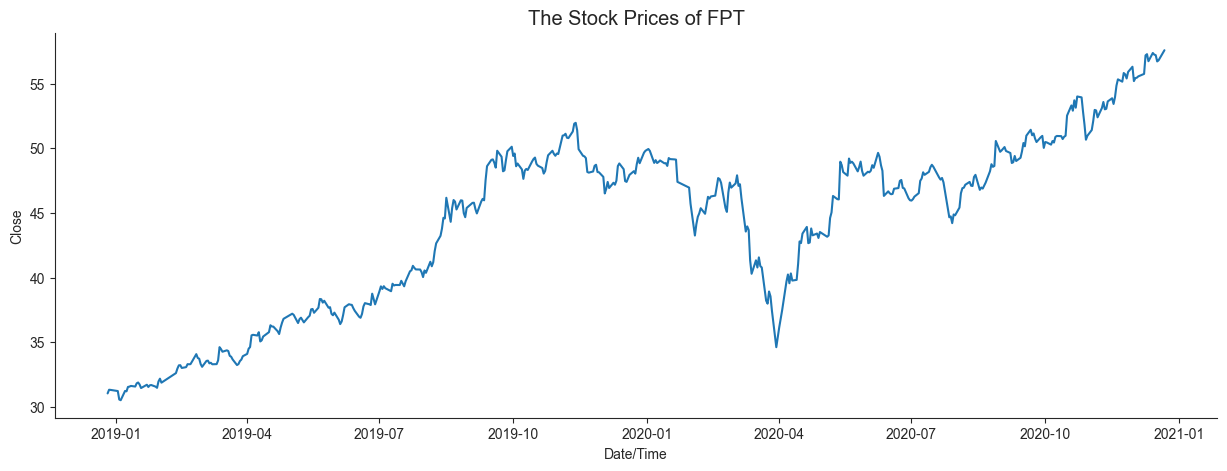

In [6]:
plt.figure(figsize=(15, 5))
sns.set_style("ticks")
sns.lineplot(data = df, x = "Date/Time", y = 'Close')
plt.title("The Stock Prices of FPT",size = 'x-large')
sns.despine()
plt.show()

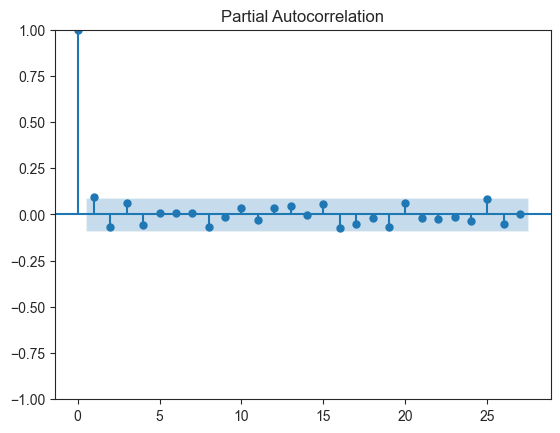

In [7]:
plot_pacf(df['Return'])
plt.show()

In [8]:
daily_volatility = df['Return'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))
monthly_volatility = np.sqrt(21) * daily_volatility
print('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))
annual_volatility = np.sqrt(252) * daily_volatility
print('Annual volatility: ', '{:.2f}%'.format(annual_volatility))

Daily volatility:  1.43%
Monthly volatility:  6.54%
Annual volatility:  22.67%


In [9]:
garch_model = arch_model(df['Return'], p=1, q=1,
                         mean='constant', vol='GARCH', dist='normal')
gm_result = garch_model.fit(disp='off')
print(gm_result.params)

mu          0.158970
omega       0.042400
alpha[1]    0.051012
beta[1]     0.926892
Name: params, dtype: float64


In [10]:
print('\n')
gm_forecast = gm_result.forecast(horizon=5)
print(gm_forecast.variance[-1:])



                 h.1       h.2       h.3       h.4       h.5
Date/Time                                                   
2020-12-22  1.155464  1.172332  1.188828  1.204959  1.220733


## Daily training

In [24]:
rolling_predictions = []
test_size = 128
for i in range(test_size):
    train = df['Return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [26]:
rolling_predictions = pd.Series(rolling_predictions, index=df['Return'].index[-test_size:])

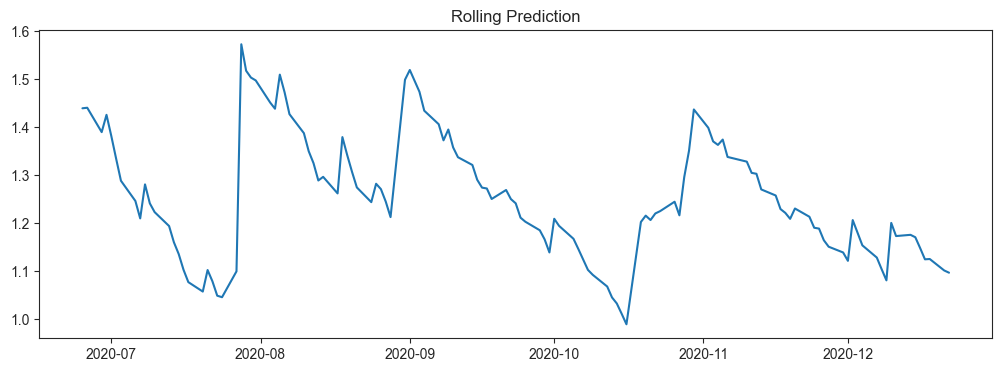

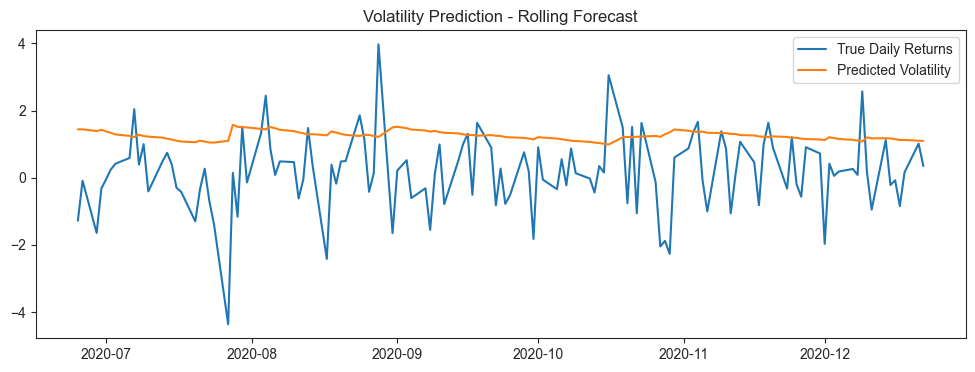

In [29]:
plt.figure(figsize=(12.3,4))
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')
plt.show()
plt.figure(figsize=(12,4))
plt.plot(df['Return'][-test_size:])
plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])
plt.show()

In [28]:
X = df['Close']
size = -128
train, test = X[0:size], X[size:]

In [15]:
model = auto_arima(train, start_p=0, start_q=0,
                   max_p=8, max_q=8, m=12,
                   start_P=0, seasonal=False,
                   d=1, D=0, trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=735.819, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=734.575, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=733.959, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=735.550, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=731.959, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=733.737, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=733.230, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=734.402, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=731.476, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=733.373, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=734.010, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=733.297, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=733.321, Time

In [16]:
# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    # Make the prediction
    output = model_fit.forecast(step = 1)
    yhat = output[0]
    return yhat

In [17]:
# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

In [23]:
rolling_predictions

Date/Time
2019-07-16    0.951049
2019-07-17    0.949055
2019-07-18    0.947624
2019-07-19    0.946084
2019-07-22    0.945092
                ...   
2020-12-16    1.148292
2020-12-17    1.124792
2020-12-18    1.125418
2020-12-21    1.101516
2020-12-22    1.096864
Length: 365, dtype: float64

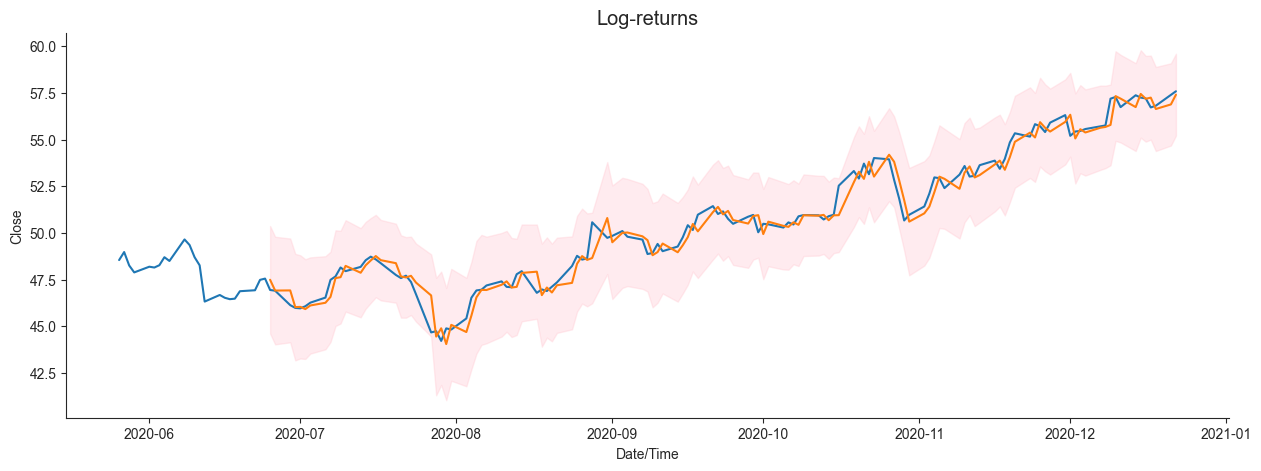

In [36]:
plt.figure(figsize=(15, 5))
sns.set_style("ticks")
sns.lineplot(data = df[-150:], x = "Date/Time", y = 'Close')
sns.lineplot(data = df[size:], x = "Date/Time", y = predictions)
plt.fill_between(df[size:].index, predictions - 2*rolling_predictions, predictions + 2*rolling_predictions, color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title("Log-returns",size = 'x-large')
sns.despine()
plt.show()

## Daily training by window size = 7

In [37]:
rolling_window_size = 7
rolling_predictions = []
test_size = 128

for i in range(test_size):
    if i < rolling_window_size:
        continue  # Bỏ qua vì không đủ dữ liệu để tạo cửa sổ trượt
    train = df['Return'][i - rolling_window_size:i]  # Lấy dữ liệu cho cửa sổ trượt hiện tại
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [39]:
rolling_predictions = pd.Series(rolling_predictions, index=df['Return'].index[-test_size+7:])

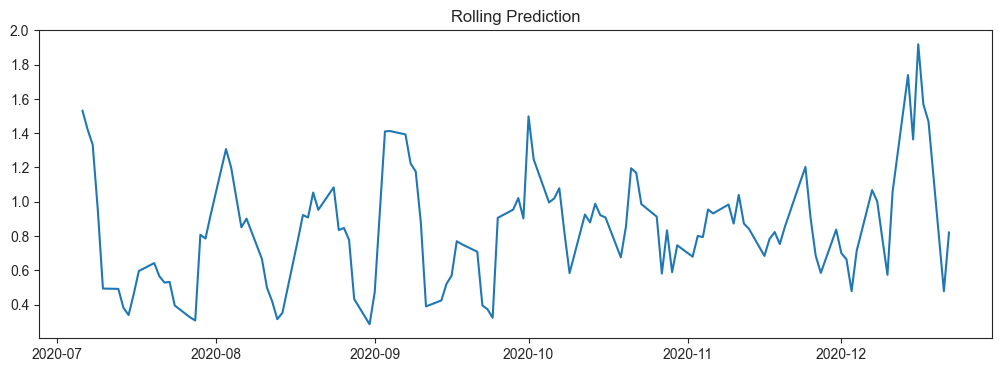

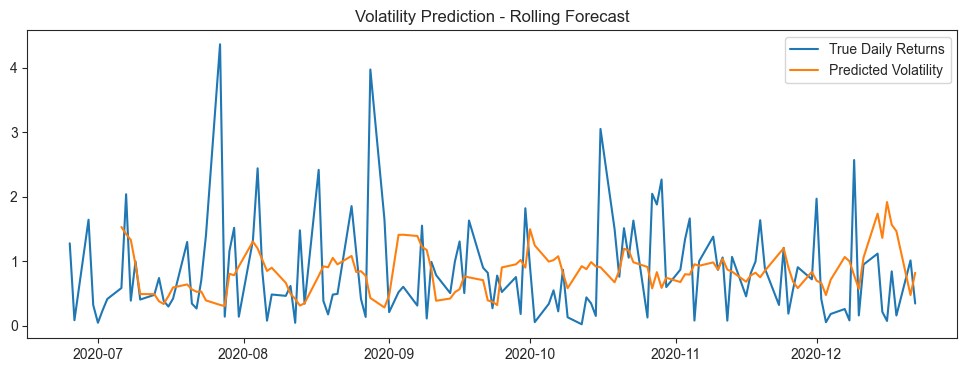

In [40]:
plt.figure(figsize=(12.3,4))
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')
plt.show()
plt.figure(figsize=(12,4))
plt.plot(np.abs(df['Return'][-test_size:]))
plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])
plt.show()

## Long-term forecast

In [82]:
X = df['Close']
size = -84
train, test = X[0:size], X[size:]
X = df['Close']
size = -84
train, test = X[0:size], X[size:]

In [83]:
model = auto_arima(train, start_p=0, start_q=0,
                   max_p=8, max_q=8, m=12,
                   start_P=0, seasonal=False,
                   d=1, D=0, trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=810.516, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=807.831, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=807.197, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=810.355, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=806.190, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=808.189, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=808.189, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=807.567, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=808.444, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=810.188, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=805.806, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=806.689, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=807.327, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=807.801, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=807.8

In [84]:
forecast = model.predict(n_periods=84)

In [85]:
model = arch_model(train, p=1, q=1)
model_fit = model.fit(disp='off')
pred = model_fit.forecast(horizon=84)
sigma = np.sqrt(pred.variance.values)

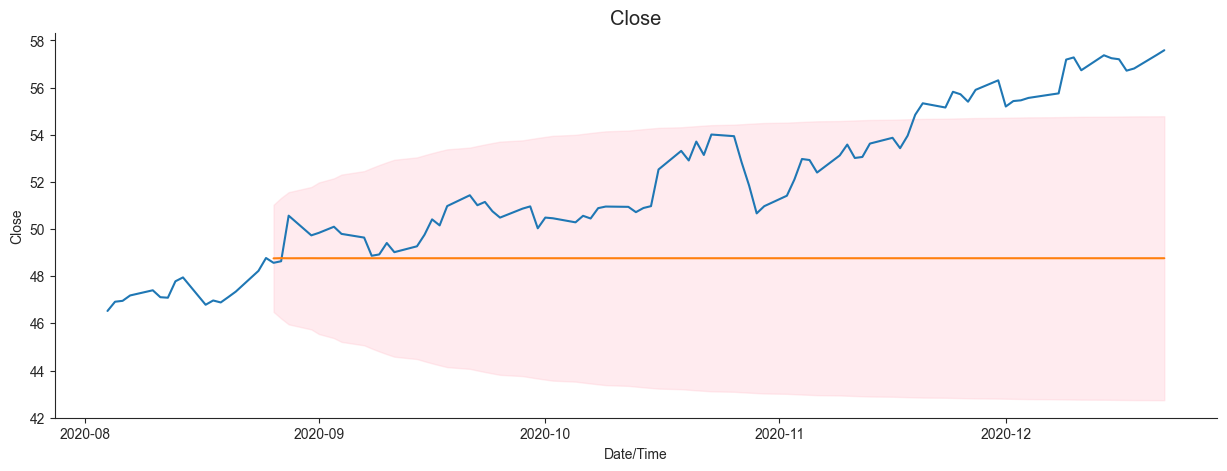

In [86]:
plt.figure(figsize=(15, 5))
sns.set_style("ticks")
sns.lineplot(data = df[-100:], x = "Date/Time", y = 'Close')
sns.lineplot(data = df[size:], x = "Date/Time", y = forecast.values)
plt.fill_between(df[size:].index, forecast.values - 2*sigma[0], forecast.values + 2*sigma[0], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title("Close",size = 'x-large')
sns.despine()
plt.show()